In [1]:
### This notebook is based on a version generously provided by Scott Pesme.
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from diag_nets import *

sns.set(font_scale=1.1)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['text.usetex'] = True


from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf')

import warnings
warnings.filterwarnings('ignore')
colors = ['olive', 'brown', 'pink', 'blue', 'orange', 'cornflowerblue', 'red', 'k', 'purple']
blue_colors = ['lightsteelblue', 'cornflowerblue', 'blue', 'midnightblue']
# red_colors = ['lightcoral', 'indianred', 'brown', 'darkred']
red_colors = ['coral', 'red', 'darkred', 'black']
label_size = 15


hps = {
    'n=80-d=200-alpha=0.1const': {'n': 80, 'd': 200, 'r': 20,  'gd': 1.0, 'gd_schedule': 2.72, 'sgd': 0.25,  'sgd_schedule': 0.282},  
    'alpha=0.1const':            {'n': 40, 'd': 100, 'r': 20,  'gd': 2.0, 'gd_schedule': 3.51,  'sgd': 0.25,  'sgd_schedule': 0.272},  
}

SGD (gamma=0.250): train loss 1.4216162873995314e-06, test loss 0.003528621943603826, l2_uv_norm 2.5705361849781974, lp 200, balancedness 0.00016493386927656734
SGD + schedule 10% (gamma=0.282): train loss 6.255816023616457e-05, test loss 0.0006594051602101788, l2_uv_norm 2.5402884044255885, lp 156, balancedness 8.938165067501848e-24
SGD + schedule 30% (gamma=0.282): train loss 5.97536626918197e-05, test loss 0.0002847392808476946, l2_uv_norm 2.537063744381602, lp 89, balancedness 1.0114221995695532e-53
SGD + schedule 50% (gamma=0.282): train loss 6.698997999358844e-05, test loss 0.00015373111459504016, l2_uv_norm 2.5375004173407, lp 71, balancedness 4.2494340308983445e-90


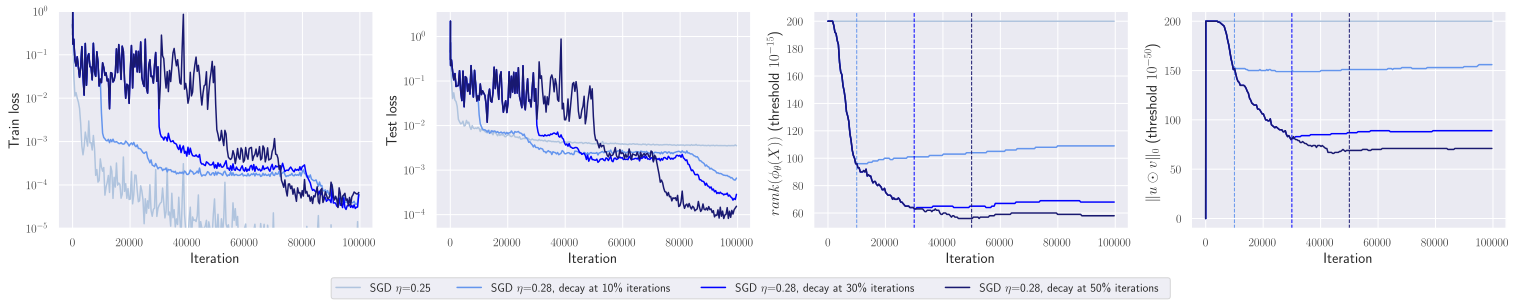

In [2]:
exp = 'n=80-d=200-alpha=0.1const'  # stabilization for SGD

np.random.seed(0) 
n = hps[exp]['n']  # number of examples
n_test = 1000
d = hps[exp]['d']  # dimension of features
r = hps[exp]['r']  # sparsity

# generate random points
H = np.eye(d)
X = np.random.multivariate_normal(np.zeros(d), H, n)
X_test = np.random.multivariate_normal(np.zeros(d), H, n_test)

# generate sparse random ground truth model, corresponds to beta^*_ell_0 in paper
theta_star = np.random.randn(d)
theta_star[r:] = 0
theta_star = np.abs(theta_star) / np.linalg.norm(theta_star)

# generate labels
y = X @ theta_star
y_test = X_test @ theta_star

x_log_scale = False
power = 5.0
num_iter = int(10**power) + 1

# n_pts_plot_first, n_pts_plot = 20, 50  
n_pts_plot_first, n_pts_plot = 100, 250
if x_log_scale:
    iters_loss_first = np.array([n_pts_plot_first])
    iters_loss_next = np.unique(np.round(np.logspace(0, power, n_pts_plot)))
else:
    iters_loss_first = np.array(range(n_pts_plot_first))
    iters_loss_next = np.unique(np.round(np.linspace(0, num_iter, n_pts_plot)))[:-1]
iters_loss = np.unique(np.concatenate((iters_loss_first, iters_loss_next)))

if 'const' in exp:
    u0, v0 = 0.1 * np.ones(d), 0.0 * np.ones(d)
else:
    u0, v0 = 0.3 * np.random.randn(d), 0.3 * np.random.randn(d)


seed = 1  # usually 1
n_plots = 4
lp_log_scale, l2_uv_log_scale = False, True
lp = 0.01
l0_threshold_power = 50
basex = 10
weight_avg_coef = 0.0  # 0.995
l0_threshold_grad_matrix = 15
valley_project = False
decay_iters, decay_factors = [[int(0.1*num_iter)], [int(0.3*num_iter)], [int(0.5*num_iter)]], [[4.8], [3.4], [1.5]]
min_train_loss_plot, max_train_loss_plot = 10**-5, 10**0

power = 2.0
num_iter_init = 1000 if 'warmup' in exp else 0  # int(10**2.0) + 1
iters_loss_init = np.unique(np.round(np.linspace(0, num_iter_init, 101)))[:-1]

gamma_gf = 0.01
np.random.seed(seed)
train_losses_gf, test_losses_gf, u_gf, v_gf, us_gf, vs_gf = GD(X, y, X_test, y_test, gamma_gf, u0, v0, iters_loss_init, num_iter_init, return_all_params=True)
lp_norms_gf = [(np.abs(u*v) > 10**-l0_threshold_power).sum() for u, v in zip(us_gf, vs_gf)]
l1_norms_gf = [np.abs(u*v).sum() for u, v in zip(us_gf, vs_gf)]
l2_uv_norms_gf = [(u**2 + v**2).sum()**0.5 for u, v in zip(us_gf, vs_gf)]
balancedness_gf = [np.linalg.norm(np.abs(u) - np.abs(v)) for u, v in zip(us_gf, vs_gf)]
if num_iter_init > 0:
    print('GD (gamma={:.3f}): train loss {}, test loss {}, l2_uv_norm {}, lp {}, balancedness {}'.format(gamma_gf, train_losses_gf[-1], test_losses_gf[-1], l2_uv_norms_gf[-1], lp_norms_gf[-1], balancedness_gf[-1]))


plt.figure(figsize=(26, 4))



gamma_sgd = hps[exp]['sgd']
for weight_avg in np.unique([0.0, weight_avg_coef]):
    np.random.seed(seed)
    train_losses, test_losses, u_sgd, v_sgd, us_sgd, vs_sgd = SGD(X, y, X_test, y_test, gamma_sgd, u_gf, v_gf, iters_loss, num_iter, thresholds=[-1], weight_avg=weight_avg, return_all_params=True, valley_project=valley_project)
    lp_norms = [(np.abs(u*v) > 10**-l0_threshold_power).sum() for u, v in zip(us_sgd, vs_sgd)]
    l1_norms = [np.abs(u*v).sum() for u, v in zip(us_sgd, vs_sgd)]
    l2_uv_norms = [(u**2 + v**2).sum()**0.5 for u, v in zip(us_sgd, vs_sgd)]
    balancedness = [np.linalg.norm(np.abs(u) - np.abs(v)) for u, v in zip(us_sgd, vs_sgd)]
    iters_loss_gf_sgd, train_losses_gf_sgd, test_losses_gf_sgd, lp_norms_gf_sgd, l1_norms_gf_sgd, l2_uv_norms_gf_sgd, balancedness_gf_sgd = np.concatenate([iters_loss_init, iters_loss + num_iter_init]), train_losses_gf + train_losses, test_losses_gf + test_losses, lp_norms_gf + lp_norms, l1_norms_gf + l1_norms, l2_uv_norms_gf + l2_uv_norms, balancedness_gf + balancedness
    grad_matrix_ranks = compute_grad_matrix_ranks(us_sgd, vs_sgd, X_test[:hps[exp]['d']*2], 10**-l0_threshold_grad_matrix)
    print('SGD (gamma={:.3f}): train loss {}, test loss {}, l2_uv_norm {}, lp {}, balancedness {}'.format(gamma_sgd, train_losses[-1], test_losses[-1], l2_uv_norms[-1], lp_norms[-1], balancedness_gf_sgd[-1]))

    label = (r'GF$\rightarrow$' if num_iter_init > 0 else '') + 'SGD ' + r'$\eta$=' + "{:.2f}".format(gamma_sgd) + ('' if weight_avg==0 else ' (AVG)')

    ax = plt.subplot(1, n_plots, 1)
    plt.plot(iters_loss_gf_sgd, train_losses_gf_sgd, label=label, color=blue_colors[0], linestyle='solid' if weight_avg==0 else '--')
    if x_log_scale:
        ax.set_xscale('log', basex=basex)
    ax.set_yscale('log')
    ax.set_ylim(min_train_loss_plot, max_train_loss_plot)
    plt.xlabel('Iteration', fontsize=label_size)
    plt.ylabel('Train loss', fontsize=label_size)

    ax = plt.subplot(1, n_plots, 2)
    plt.plot(iters_loss_gf_sgd, test_losses_gf_sgd, label=label, color=blue_colors[0], linestyle='solid' if weight_avg==0 else '--')
    if x_log_scale:
        ax.set_xscale('log', basex=basex)
    ax.set_yscale('log')
    plt.xlabel('Iteration', fontsize=label_size)
    plt.ylabel('Test loss', fontsize=label_size)

    ax = plt.subplot(1, n_plots, 3)
    plt.plot(iters_loss, grad_matrix_ranks, label=label, color=blue_colors[0], linestyle='solid')
    if x_log_scale:
        ax.set_xscale('log')
    plt.xlabel('Iteration', fontsize=label_size)
    plt.ylabel('$rank(\phi_\\theta(X))$ (threshold {})'.format(l0_threshold_grad_matrix), fontsize=label_size)
    # plt.legend()

    ax = plt.subplot(1, n_plots, 4)
    plt.plot(iters_loss_gf_sgd, lp_norms_gf_sgd, label=label, color=blue_colors[0], linestyle='solid' if weight_avg==0 else '--')
    if x_log_scale:
        ax.set_xscale('log', basex=basex)
    if lp_log_scale:
        ax.set_yscale('log')
    plt.xlabel('Iteration', fontsize=label_size)
    plt.ylabel('$rank(\phi_\\theta(X))$ (threshold $10^{-' + str(l0_threshold_grad_matrix) + '}$)', fontsize=label_size)


gamma_sgd_schedule = hps[exp]['sgd_schedule']
for i, (decay_iter, decay_factor) in enumerate(zip(decay_iters, decay_factors)):
    for weight_avg in np.unique([0.0, weight_avg_coef]):
        np.random.seed(seed)
        train_losses, test_losses, u_sgd, v_sgd, us_sgd, vs_sgd = SGD(X, y, X_test, y_test, gamma_sgd_schedule, u_gf, v_gf, iters_loss, num_iter, thresholds=decay_iter, decays=decay_factor, weight_avg=weight_avg, return_all_params=True, valley_project=valley_project)
        lp_norms = [(np.abs(u*v) > 10**-l0_threshold_power).sum() for u, v in zip(us_sgd, vs_sgd)]
        l1_norms = [np.abs(u*v).sum() for u, v in zip(us_sgd, vs_sgd)]
        l2_uv_norms = [(u**2 + v**2).sum()**0.5 for u, v in zip(us_sgd, vs_sgd)]
        balancedness = [np.linalg.norm(np.abs(u) - np.abs(v)) for u, v in zip(us_sgd, vs_sgd)]
        iters_loss_gf_sgd, train_losses_gf_sgd, test_losses_gf_sgd, lp_norms_gf_sgd, l1_norms_gf_sgd, l2_uv_norms_gf_sgd, balancedness_gf_sgd = np.concatenate([iters_loss_init, iters_loss + num_iter_init]), train_losses_gf + train_losses, test_losses_gf + test_losses, lp_norms_gf + lp_norms, l1_norms_gf + l1_norms, l2_uv_norms_gf + l2_uv_norms, balancedness_gf + balancedness
        grad_matrix_ranks = compute_grad_matrix_ranks(us_sgd, vs_sgd, X_test[:hps[exp]['d']*2], 10**-l0_threshold_grad_matrix)
        schedule_str = '{:.0%}'.format(decay_iter[0] / num_iter)
        print('SGD + schedule {} (gamma={:.3f}): train loss {}, test loss {}, l2_uv_norm {}, lp {}, balancedness {}'.format(schedule_str, gamma_sgd_schedule, train_losses[-1], test_losses[-1], l2_uv_norms[-1], lp_norms[-1], balancedness_gf_sgd[-1]))

        label = (r'GF$\rightarrow$' if num_iter_init > 0 else '') + 'SGD $\eta$=' + "{:.2f}".format(gamma_sgd_schedule) + ', decay at ' + schedule_str[:-1] + r'\% iterations' + ('' if weight_avg==0 else ' (AVG)')

        ax = plt.subplot(1, n_plots, 1)
        plt.plot(iters_loss_gf_sgd, train_losses_gf_sgd, label=label, color=blue_colors[i+1], linestyle='solid' if weight_avg==0 else '--')
        if x_log_scale:
            ax.set_xscale('log', basex=basex)
        ax.set_yscale('log')
        ax.set_ylim(min_train_loss_plot, max_train_loss_plot)
        plt.xlabel('Iteration', fontsize=label_size)
        plt.ylabel('Train loss', fontsize=label_size)

        ax = plt.subplot(1, n_plots, 2)
        plt.plot(iters_loss_gf_sgd, test_losses_gf_sgd, label=label, color=blue_colors[i+1], linestyle='solid' if weight_avg==0 else '--')
        if x_log_scale:
            ax.set_xscale('log', basex=basex)
        ax.set_yscale('log')
        plt.xlabel('Iteration', fontsize=label_size)
        plt.ylabel('Test loss', fontsize=label_size)

        ax = plt.subplot(1, n_plots, 3)
        plt.plot(iters_loss, grad_matrix_ranks, label=label, color=blue_colors[i+1], linestyle='solid')
        if decay_iters[i][0] > 0:
            plt.axvline(x=decay_iters[i][0], color=blue_colors[i+1], linestyle='--', linewidth=1)
        if x_log_scale:
            ax.set_xscale('log')
        plt.xlabel('Iteration', fontsize=label_size)
        plt.ylabel('$rank(\phi_\\theta(X))$ (threshold $10^{-' + str(l0_threshold_grad_matrix) + '}$)', fontsize=label_size)
        
        # plt.legend()

        ax = plt.subplot(1, n_plots, 4)
        plt.plot(iters_loss_gf_sgd, lp_norms_gf_sgd, label=label, color=blue_colors[i+1], linestyle='solid' if weight_avg==0 else '--')
        if decay_iters[i][0] > 0:
            plt.axvline(x=decay_iters[i][0], color=blue_colors[i+1], linestyle='--', linewidth=1)
        if x_log_scale:
            ax.set_xscale('log', basex=basex)
        if lp_log_scale:
            ax.set_yscale('log')
        plt.xlabel('Iteration', fontsize=label_size)
        plt.ylabel('$\| u \odot v \|_0$ (threshold $10^{-' + str(l0_threshold_power) + '}$)', fontsize=label_size)

        
# plt.legend(loc='upper center', bbox_to_anchor=(-2.0, -0.2), ncol=7)
plt.legend(loc='upper center', bbox_to_anchor=(-1.4, -0.2), ncol=7)
plt.savefig("plots/loss_surfaces_stabilization_exp={}_lp={}.pdf".format(exp, lp), bbox_inches='tight')
plt.show()

GD (gamma=2.000): train loss 4.429638872090642e-34, test loss 0.16824144824688475, l2_uv_norm 2.8749151062392273, lp 100, balancedness 0.43518739406748264
0.6490066984718681
GD + schedule 10% (gamma=3.530): train loss 7.2084668923497655e-31, test loss 0.44924758807701687, l2_uv_norm 3.429456662290854, lp 86, balancedness 7.218776836330644e-40
GD + schedule 30% (gamma=3.530): train loss 2.655953689807218e-31, test loss 0.4380760171039043, l2_uv_norm 3.3241534187332586, lp 80, balancedness 2.9364750853125797e-114
GD + schedule 50% (gamma=3.530): train loss 2.330375232708555e-33, test loss 0.49728716986921523, l2_uv_norm 3.469221336628268, lp 78, balancedness 0.0
0.6490066984718681
SGD + schedule 50% (gamma=0.272): train loss 0.0008896430460425727, test loss 0.03851229274577084, l2_uv_norm 2.627847660895007, lp 33, balancedness 0.0


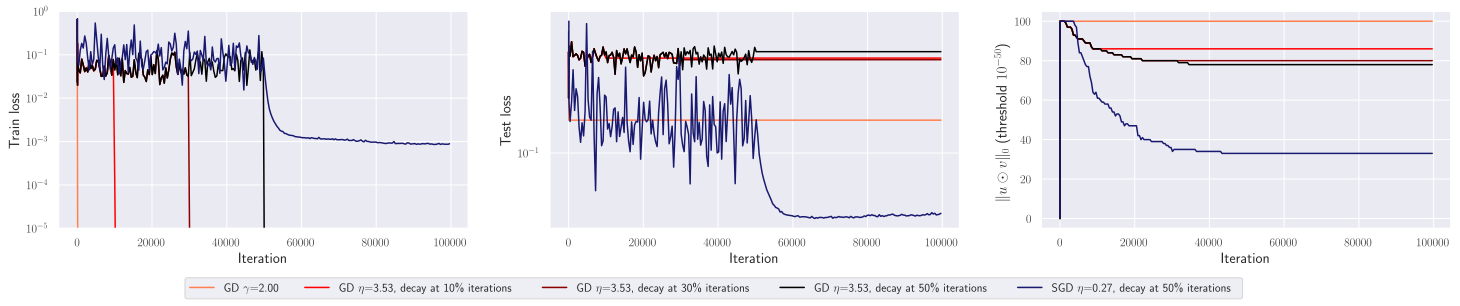

In [3]:
exp = 'alpha=0.1const'  # stabilization for GD

np.random.seed(0)  
n = hps[exp]['n']  # number of examples
n_test = 1000
d = hps[exp]['d']  # dimension of features
r = hps[exp]['r']  # sparsity

# generate random points
H = np.eye(d)
X = np.random.multivariate_normal(np.zeros(d), H, n)
X_test = np.random.multivariate_normal(np.zeros(d), H, n_test)

# generate sparse random ground truth model, corresponds to beta^*_ell_0 in paper
theta_star = np.random.randn(d)
theta_star[r:] = 0
theta_star = np.abs(theta_star) / np.linalg.norm(theta_star)

# generate labels
y = X @ theta_star
y_test = X_test @ theta_star

x_log_scale = False
power = 5.0
num_iter = int(10**power) + 1

# n_pts_plot_first, n_pts_plot = 20, 50  
n_pts_plot_first, n_pts_plot = 100, 250
if x_log_scale:
    iters_loss_first = np.array([n_pts_plot_first])
    iters_loss_next = np.unique(np.round(np.logspace(0, power, n_pts_plot)))
else:
    iters_loss_first = np.array(range(n_pts_plot_first))
    iters_loss_next = np.unique(np.round(np.linspace(0, num_iter, n_pts_plot)))[:-1]
iters_loss = np.unique(np.concatenate((iters_loss_first, iters_loss_next)))

if 'const' in exp:
    u0, v0 = 0.1 * np.ones(d), 0.0 * np.ones(d)
else:
    u0, v0 = 0.3 * np.random.randn(d), 0.3 * np.random.randn(d)



seed = 1  # usually 1
n_plots = 3
lp_log_scale, l2_uv_log_scale = False, True
lp = 0.01
l0_threshold_power = 50
basex = 10
weight_avg_coef = 0.0  # 0.995
valley_project = False
decay_iters, decay_factors = [[int(0.1*num_iter)], [int(0.3*num_iter)], [int(0.5*num_iter)]], [[4.8], [3.4], [1.5]]
min_train_loss_plot, max_train_loss_plot = 10**-5, 10**0

# GF->GD and GF->SGD to see stabilization at different level sets
power = 2.0
num_iter_init = 1000 if 'warmup' in exp else 0  # int(10**2.0) + 1
iters_loss_init = np.unique(np.round(np.linspace(0, num_iter_init, 101)))[:-1]

gamma_gf = 0.01
np.random.seed(seed)
train_losses_gf, test_losses_gf, u_gf, v_gf, us_gf, vs_gf = GD(X, y, X_test, y_test, gamma_gf, u0, v0, iters_loss_init, num_iter_init, return_all_params=True)
lp_norms_gf = [(np.abs(u*v) > 10**-l0_threshold_power).sum() for u, v in zip(us_gf, vs_gf)]
l1_norms_gf = [np.abs(u*v).sum() for u, v in zip(us_gf, vs_gf)]
l2_uv_norms_gf = [(u**2 + v**2).sum()**0.5 for u, v in zip(us_gf, vs_gf)]
balancedness_gf = [np.linalg.norm(np.abs(u) - np.abs(v)) for u, v in zip(us_gf, vs_gf)]
if num_iter_init > 0:
    print('GD (gamma={:.3f}): train loss {}, test loss {}, l2_uv_norm {}, lp {}, balancedness {}'.format(gamma_gf, train_losses_gf[-1], test_losses_gf[-1], l2_uv_norms_gf[-1], lp_norms_gf[-1], balancedness_gf[-1]))


plt.figure(figsize=(25, 4))
# plt.figure(figsize=(30, 3.5))


gamma_gd_schedule = hps[exp]['gd']  # 2.632; 3.1
for weight_avg in np.unique([0.0, weight_avg_coef]):
    train_losses, test_losses, u_gd, v_gd, us_gd, vs_gd = GD(X, y, X_test, y_test, gamma_gd_schedule, u_gf, v_gf, iters_loss, num_iter, thresholds=[-1], decays=[-1], weight_avg=weight_avg, return_all_params=True, valley_project=valley_project)
    lp_norms = [(np.abs(u*v) > 10**-l0_threshold_power).sum() for u, v in zip(us_gd, vs_gd)]
    l2_uv_norms = [(u**2 + v**2).sum()**0.5 for u, v in zip(us_gd, vs_gd)]
    l1_norms = [np.abs(u*v).sum() for u, v in zip(us_gd, vs_gd)]
    balancedness = [np.linalg.norm(np.abs(u) - np.abs(v)) for u, v in zip(us_gd, vs_gd)]
    iters_loss_gf_gd, train_losses_gf_gd, test_losses_gf_gd, lp_norms_gf_gd, l2_uv_norms_gf_gd, balancedness_gf_gd = np.concatenate([iters_loss_init, iters_loss + num_iter_init]), train_losses_gf + train_losses, test_losses_gf + test_losses, lp_norms_gf + lp_norms, l2_uv_norms_gf + l2_uv_norms, balancedness_gf + balancedness
    print('GD (gamma={:.3f}): train loss {}, test loss {}, l2_uv_norm {}, lp {}, balancedness {}'.format(gamma_gd_schedule, train_losses[-1], test_losses[-1], l2_uv_norms[-1], lp_norms[-1], balancedness[-1]))

    label = (r'GF$\rightarrow$' if num_iter_init > 0 else '') + 'GD 'r'$\gamma$=' + "{:.2f}".format(gamma_gd_schedule) + ('' if weight_avg==0 else ' (AVG)')

    ax = plt.subplot(1, n_plots, 1)
    plt.plot(iters_loss_gf_gd, train_losses_gf_gd, label=label, color=red_colors[0], linestyle='solid' if weight_avg==0 else '--')
    if x_log_scale:
        ax.set_xscale('log')
    ax.set_yscale('log')
    # ax.set_ylim(min_train_loss_plot, max_train_loss_plot)
    plt.xlabel('Iteration', fontsize=label_size)
    plt.ylabel('Train loss', fontsize=label_size)

    ax = plt.subplot(1, n_plots, 2)
    plt.plot(iters_loss_gf_gd, test_losses_gf_gd, label=label, color=red_colors[0], linestyle='solid' if weight_avg==0 else '--')
    if x_log_scale:
        ax.set_xscale('log')
    ax.set_yscale('log')
    plt.xlabel('Iteration', fontsize=label_size)
    plt.ylabel('Test loss', fontsize=label_size)

    ax = plt.subplot(1, n_plots, 3)
    plt.plot(iters_loss_gf_gd, lp_norms_gf_gd, label=label, color=red_colors[0], linestyle='solid' if weight_avg==0 else '--')
    if x_log_scale:
        ax.set_xscale('log')
    if lp_log_scale:
        ax.set_yscale('log')
    plt.xlabel('Iteration', fontsize=label_size)
    plt.ylabel('$\ell_0$-norm (threshold $10^{-' + str(l0_threshold_power) + '}$)', fontsize=label_size)

print(train_losses[0])

gamma_sgd_schedule = 3.53  # hps[exp]['gd_schedule']; 3.53 is pretty good
for i, (decay_iter, decay_factor) in enumerate(zip(decay_iters, decay_factors)):
    for weight_avg in np.unique([0.0, weight_avg_coef]):
        np.random.seed(seed)
        train_losses, test_losses, u_sgd, v_sgd, us_sgd, vs_sgd = GD(X, y, X_test, y_test, gamma_sgd_schedule, u_gf, v_gf, iters_loss, num_iter, thresholds=decay_iter, decays=decay_factor, weight_avg=weight_avg, return_all_params=True, valley_project=valley_project)
        lp_norms = [(np.abs(u*v) > 10**-l0_threshold_power).sum() for u, v in zip(us_sgd, vs_sgd)]
        l1_norms = [np.abs(u*v).sum() for u, v in zip(us_sgd, vs_sgd)]
        l2_uv_norms = [(u**2 + v**2).sum()**0.5 for u, v in zip(us_sgd, vs_sgd)]
        balancedness = [np.linalg.norm(np.abs(u) - np.abs(v)) for u, v in zip(us_sgd, vs_sgd)]
        iters_loss_gf_sgd, train_losses_gf_sgd, test_losses_gf_sgd, lp_norms_gf_sgd, l1_norms_gf_sgd, l2_uv_norms_gf_sgd, balancedness_gf_sgd = np.concatenate([iters_loss_init, iters_loss + num_iter_init]), train_losses_gf + train_losses, test_losses_gf + test_losses, lp_norms_gf + lp_norms, l1_norms_gf + l1_norms, l2_uv_norms_gf + l2_uv_norms, balancedness_gf + balancedness
        schedule_str = '{:.0%}'.format(decay_iter[0] / num_iter)
        print('GD + schedule {} (gamma={:.3f}): train loss {}, test loss {}, l2_uv_norm {}, lp {}, balancedness {}'.format(schedule_str, gamma_sgd_schedule, train_losses[-1], test_losses[-1], l2_uv_norms[-1], lp_norms[-1], balancedness_gf_sgd[-1]))

        label = (r'GF$\rightarrow$' if num_iter_init > 0 else '') + 'GD $\eta$=' + "{:.2f}".format(gamma_sgd_schedule) + ', decay at ' + schedule_str[:-1] + r'\% iterations' + ('' if weight_avg==0 else ' (AVG)')

        ax = plt.subplot(1, n_plots, 1)
        plt.plot(iters_loss_gf_sgd, train_losses_gf_sgd, label=label, color=red_colors[i+1], linestyle='solid' if weight_avg==0 else '--')
        if x_log_scale:
            ax.set_xscale('log', basex=basex)
        ax.set_yscale('log')
        # ax.set_ylim(min_train_loss_plot, max_train_loss_plot)
        plt.xlabel('Iteration', fontsize=label_size)
        plt.ylabel('Train loss', fontsize=label_size)

        ax = plt.subplot(1, n_plots, 2)
        plt.plot(iters_loss_gf_sgd, test_losses_gf_sgd, label=label, color=red_colors[i+1], linestyle='solid' if weight_avg==0 else '--')
        if x_log_scale:
            ax.set_xscale('log', basex=basex)
        ax.set_yscale('log')
        plt.xlabel('Iteration', fontsize=label_size)
        plt.ylabel('Test loss', fontsize=label_size)

        ax = plt.subplot(1, n_plots, 3)
        plt.plot(iters_loss_gf_sgd, lp_norms_gf_sgd, label=label, color=red_colors[i+1], linestyle='solid' if weight_avg==0 else '--')
        if x_log_scale:
            ax.set_xscale('log', basex=basex)
        if lp_log_scale:
            ax.set_yscale('log')
        plt.xlabel('Iteration', fontsize=label_size)
        plt.ylabel('$\| u \odot v \|_0$ (threshold $10^{-' + str(l0_threshold_power) + '}$)', fontsize=label_size)

print(train_losses[0])

decay_iters, decay_factors = [[int(0.5*num_iter)]], [[20.0]]
gamma_sgd_schedule = hps[exp]['sgd_schedule']
for i, (decay_iter, decay_factor) in enumerate(zip(decay_iters[-1:], decay_factors[-1:])):
    for weight_avg in np.unique([0.0, weight_avg_coef]):
        np.random.seed(seed)
        train_losses, test_losses, u_sgd, v_sgd, us_sgd, vs_sgd = SGD(X, y, X_test, y_test, gamma_sgd_schedule, u_gf, v_gf, iters_loss, num_iter, thresholds=decay_iter, decays=decay_factor, weight_avg=weight_avg, return_all_params=True, valley_project=valley_project)
        lp_norms = [(np.abs(u*v) > 10**-l0_threshold_power).sum() for u, v in zip(us_sgd, vs_sgd)]
        l1_norms = [np.abs(u*v).sum() for u, v in zip(us_sgd, vs_sgd)]
        l2_uv_norms = [(u**2 + v**2).sum()**0.5 for u, v in zip(us_sgd, vs_sgd)]
        balancedness = [np.linalg.norm(np.abs(u) - np.abs(v)) for u, v in zip(us_sgd, vs_sgd)]
        iters_loss_gf_sgd, train_losses_gf_sgd, test_losses_gf_sgd, lp_norms_gf_sgd, l1_norms_gf_sgd, l2_uv_norms_gf_sgd, balancedness_gf_sgd = np.concatenate([iters_loss_init, iters_loss + num_iter_init]), train_losses_gf + train_losses, test_losses_gf + test_losses, lp_norms_gf + lp_norms, l1_norms_gf + l1_norms, l2_uv_norms_gf + l2_uv_norms, balancedness_gf + balancedness
        schedule_str = '{:.0%}'.format(decay_iter[0] / num_iter)
        print('SGD + schedule {} (gamma={:.3f}): train loss {}, test loss {}, l2_uv_norm {}, lp {}, balancedness {}'.format(schedule_str, gamma_sgd_schedule, train_losses[-1], test_losses[-1], l2_uv_norms[-1], lp_norms[-1], balancedness_gf_sgd[-1]))

        label = (r'GF$\rightarrow$' if num_iter_init > 0 else '') + 'SGD $\eta$=' + "{:.2f}".format(gamma_sgd_schedule) + ', decay at ' + schedule_str[:-1] + r'\% iterations' + ('' if weight_avg==0 else ' (AVG)')

        ax = plt.subplot(1, n_plots, 1)
        plt.plot(iters_loss_gf_sgd, train_losses_gf_sgd, label=label, color=blue_colors[-1], linestyle='solid' if weight_avg==0 else '--')
        if x_log_scale:
            ax.set_xscale('log', basex=basex)
        ax.set_yscale('log')
        ax.set_ylim(min_train_loss_plot, max_train_loss_plot)
        plt.xlabel('Iteration', fontsize=label_size)
        plt.ylabel('Train loss', fontsize=label_size)

        ax = plt.subplot(1, n_plots, 2)
        plt.plot(iters_loss_gf_sgd, test_losses_gf_sgd, label=label, color=blue_colors[-1], linestyle='solid' if weight_avg==0 else '--')
        if x_log_scale:
            ax.set_xscale('log', basex=basex)
        ax.set_yscale('log')
        plt.xlabel('Iteration', fontsize=label_size)
        plt.ylabel('Test loss', fontsize=label_size)

        ax = plt.subplot(1, n_plots, 3)
        plt.plot(iters_loss_gf_sgd, lp_norms_gf_sgd, label=label, color=blue_colors[-1], linestyle='solid' if weight_avg==0 else '--')
        if x_log_scale:
            ax.set_xscale('log', basex=basex)
        if lp_log_scale:
            ax.set_yscale('log')
        plt.xlabel('Iteration', fontsize=label_size)
        plt.ylabel('$\| u \odot v \|_0$ (threshold $10^{-' + str(l0_threshold_power) + '}$)', fontsize=label_size)

        
# plt.legend(loc='upper center', bbox_to_anchor=(-2.0, -0.2), ncol=7)
plt.legend(loc='upper center', bbox_to_anchor=(-0.8, -0.2), ncol=7)
plt.savefig("plots/loss_surfaces_stabilization_gd_exp={}_lp={}.pdf".format(exp, lp), bbox_inches='tight')
plt.show()